In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Scale and crop the images to 1520*870

In [ ]:
from PIL import Image
import os

# Define the required minimum dimensions and crop dimensions
min_width = 1520
min_height = 870
crop_width = 1520
crop_height = 870

# Function to resize and crop the image while maintaining aspect ratio
def resize_and_crop_image(image_path, output_path):
    with Image.open(image_path) as img:
        original_width, original_height = img.size

        # Calculate the scale factor to meet the minimum requirements
        scale_factor = max(min_width / original_width, min_height / original_height)

        # Calculate the new dimensions
        new_width = int(original_width * scale_factor)
        new_height = int(original_height * scale_factor)

        # Resize the image
        resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)

        # Calculate coordinates to crop the image to the center
        left = (new_width - crop_width) / 2
        top = (new_height - crop_height) / 2
        right = (new_width + crop_width) / 2
        bottom = (new_height + crop_height) / 2

        # Crop the image
        cropped_img = resized_img.crop((left, top, right, bottom))

        # Save the cropped image
        cropped_img.save(output_path)
        print(f"Resized and cropped image saved as: {output_path}")

# Define the input and output directories
input_dir = '/content/drive/MyDrive/TIL_personal/background_dataset_selected'
output_dir = '/content/drive/MyDrive/TIL_personal/background_dataset_scaled'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        resize_and_crop_image(input_path, output_path)

<ipython-input-3-23c8128d656d>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)


Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/background_dataset_scaled/00000691_(3).jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/background_dataset_scaled/00000687_(2).jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/background_dataset_scaled/00000689.jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/background_dataset_scaled/00000688.jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/background_dataset_scaled/00000693.jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/background_dataset_scaled/00000691.jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/background_dataset_scaled/00000685_(2).jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/background_dataset_scaled/00000692_(2).jpg
Resized and cropped image saved as: /content/drive/MyDrive/TIL_personal/background_dataset_scale

#Add targets and bboxes

In [ ]:
import os
import random
import json
from PIL import Image

# Directories for the images
big_images_dir = '/content/drive/MyDrive/TIL_personal/background_dataset_scaled'
small_images_dir = '/content/drive/MyDrive/TIL_personal/images_no_background'
output_dir = '/content/drive/MyDrive/TIL_personal/images_integrated'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

def check_overlap(bbox1, bbox2):
    left1, top1, width1, height1 = bbox1
    left2, top2, width2, height2 = bbox2

    right1 = left1 + width1
    bottom1 = top1 + height1
    right2 = left2 + width2
    bottom2 = top2 + height2

    return not (right1 <= left2 or right2 <= left1 or bottom1 <= top2 or bottom2 <= top1)

# Function to randomly select, rotate, resize and place small images
def process_images(big_image_path):
    with Image.open(big_image_path) as big_img:
        big_width, big_height = big_img.size

        annotations = []

        small_images = random.sample(os.listdir(small_images_dir), 4)
        for small_image_filename in small_images:
            small_image_path = os.path.join(small_images_dir, small_image_filename)
            with Image.open(small_image_path) as small_img:
                # Rotate the small image
                angle = random.uniform(-180, 180)
                rotated_img = small_img.rotate(angle, expand=True)

                # Calculate scale factor and resize the rotated image
                scale_factor = random.uniform(0.03, 0.10)
                new_width = int(big_width * scale_factor)
                new_height = int(big_height * scale_factor)
                scaled_img = rotated_img.resize((new_width, new_height), Image.ANTIALIAS)

                while True:
                    # Randomly place the small image on the big image
                    max_left = int(0.9 * big_width) - new_width
                    max_top = int(0.9 * big_height) - new_height
                    left = random.randint(int(0.1 * big_width), max_left)
                    top = random.randint(int(0.1 * big_height), max_top)
                    bbox = [left, top, new_width, new_height]

                    # Check for overlap with existing annotations
                    overlap = False
                    for annotation in annotations:
                        if check_overlap(bbox, annotation["bbox"]):
                            overlap = True
                            break

                    if not overlap:
                        break

                big_img.paste(scaled_img, (left, top), scaled_img.convert("RGBA"))
                caption = small_image_filename[:-4].split('_')
                try:
                    int(caption[-1])
                    caption = caption[:-1]
                    caption = ' '.join(caption)
                except:
                    caption = ' '.join(caption)
                #print(caption)
                # Record the annotation
                annotation = {
                    "caption": caption,
                    "bbox": [left, top, new_width, new_height]
                }
                annotations.append(annotation)

        # Save the new image
        output_image_path = os.path.join(output_dir, os.path.basename(big_image_path))
        big_img.save(output_image_path)

        return os.path.basename(big_image_path), annotations

# Process each big image and collect annotations
all_annotations = []
for big_image_filename in os.listdir(big_images_dir):
    if big_image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        big_image_path = os.path.join(big_images_dir, big_image_filename)
        image_name, annotations = process_images(big_image_path)
        all_annotations.append({
            "image": image_name,
            "annotations": annotations
        })

# Save annotations to a JSON file
output_json_path = os.path.join('/content/drive/MyDrive/TIL_personal/annotations.json')
with open(output_json_path, 'w') as json_file:
    json.dump(all_annotations, json_file, indent=4)

print(f"Annotations saved to {output_json_path}")

<ipython-input-3-11be8b6aaee2>:44: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  scaled_img = rotated_img.resize((new_width, new_height), Image.ANTIALIAS)


white drone
white yellow and black helicopter
white rocket
grey and white missile
red hot air balloon
orange camouflage fighter jet
flying saucer
white rocket
purple and blue drone
white and blue hot air balloon
white and red hot air balloon
grey and white fighter plane
grey and white fighter plane
grey camouflage fighter jet
grey missile
yellow and red hot air balloon
grey and white missile
red hot air balloon
red hot air balloon
blue drone
grey camouflage fighter jet
blue helicopter
grey fighter jet
blue fighter jet
grey drone
grey and white fighter plane
white drone
grey fighter jet
yellow and red hot air balloon
white and black light aircraft
blue white and black commercial aircraft
red commercial aircraft
grey and white fighter plane
white black and blue drone
blue fighter jet
blue white and black commercial aircraft
white and red drone
blue fighter plane
grey and white missile
red hot air balloon
white fighter plane
white yellow and black helicopter
white rocket
orange and white 

## Append extra targets and bboxes

In [ ]:
import os
import random
import json
from PIL import Image

# Directories for the images
big_images_dir = '/content/drive/MyDrive/TIL_personal/extra_data'
small_images_dir = '/content/drive/MyDrive/TIL_personal/images_no_background'
extra_images_dir = '/content/drive/MyDrive/TIL_personal/extra_images'
output_dir = '/content/drive/MyDrive/TIL_personal/images_integrated'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Function to check for overlap between bounding boxes
def check_overlap(bbox1, bbox2):
    left1, top1, width1, height1 = bbox1
    left2, top2, width2, height2 = bbox2

    right1 = left1 + width1
    bottom1 = top1 + height1
    right2 = left2 + width2
    bottom2 = top2 + height2

    return not (right1 <= left2 or right2 <= left1 or bottom1 <= top2 or bottom2 <= top1)

# Function to randomly select, rotate, resize and place small images
def process_images(big_image_path, specific_image = ''):
    with Image.open(big_image_path) as big_img:
        big_width, big_height = big_img.size

        annotations = []
        small_images = []

        extra = False
        # List of small images ensuring 'specific_small_image.jpg' is included
        if specific_image == '':
            small_images = random.sample(os.listdir(extra_images_dir), 4)
            extra = True
        else:
            small_images = [specific_image] + random.sample(
                [img for img in os.listdir(small_images_dir)],
                3
            )

        for i, small_image_filename in enumerate(small_images):
            small_image_path = ''
            if extra:
                small_image_path = os.path.join(extra_images_dir, small_image_filename)
            else:
                if i == 0:
                    small_image_path = os.path.join(extra_images_dir, small_image_filename)
                else:
                    small_image_path = os.path.join(small_images_dir, small_image_filename)
            with Image.open(small_image_path) as small_img:
                # Rotate the small image
                angle = random.uniform(-180, 180)
                rotated_img = small_img.rotate(angle, expand=True)

                # Calculate scale factor and resize the rotated image
                scale_factor = random.uniform(0.03, 0.10)
                new_width = int(big_width * scale_factor)
                new_height = int(big_height * scale_factor)
                scaled_img = rotated_img.resize((new_width, new_height), Image.ANTIALIAS)

                # Ensure the image does not overlap with already placed images
                while True:
                    # Randomly place the small image on the big image
                    max_left = int(0.9 * big_width) - new_width
                    max_top = int(0.9 * big_height) - new_height
                    left = random.randint(int(0.1 * big_width), max_left)
                    top = random.randint(int(0.1 * big_height), max_top)
                    bbox = [left, top, new_width, new_height]

                    # Check for overlap with existing annotations
                    overlap = False
                    for annotation in annotations:
                        if check_overlap(bbox, annotation["bbox"]):
                            overlap = True
                            break

                    if not overlap:
                        break

                big_img.paste(scaled_img, (left, top), scaled_img.convert("RGBA"))
                caption = small_image_filename[:-4].split('_')
                try:
                    int(caption[-1])
                    caption = caption[:-1]
                    caption = ' '.join(caption)
                except:
                    caption = ' '.join(caption)
                # Record the annotation
                annotation = {
                    "caption": caption,
                    "bbox": [left, top, new_width, new_height]
                }
                annotations.append(annotation)

        # Save the new image
        output_image_path = os.path.join(output_dir, os.path.basename(big_image_path))
        big_img.save(output_image_path)

        return os.path.basename(big_image_path), annotations

# Process the first 100 big images and collect annotations
all_annotations = []
big_images = [img for img in os.listdir(big_images_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
for i, big_image_filename in enumerate(big_images[:100]):
    big_image_path = os.path.join(big_images_dir, big_image_filename)
    specific_image = ''
    if i < 15:
        specific_image = 'green_and_black_glider.png'
    elif i < 30:
        specific_image = 'grey_blue_and_yellow_blimp.png'
    elif i < 45:
        specific_image = 'white_and_black_airship.png'
    elif i < 60:
        specific_image = 'white_and_black_space_shuttle.png'
    elif i < 75:
        specific_image = 'white_blimp.png'
    elif i < 90:
        specific_image = 'white_glider.png'
    image_name, annotations = process_images(big_image_path, specific_image)
    all_annotations.append({
        "image": image_name,
        "annotations": annotations
    })
    print(f"Processed image {i+1}/100")

# Save annotations to a JSON file
output_json_path = os.path.join('/content/drive/MyDrive/TIL_personal/annotations.json')

# Check if the file already exists
if os.path.exists(output_json_path):
    with open(output_json_path, 'r') as json_file:
        existing_data = json.load(json_file)
else:
    existing_data = []

# Append new data to the existing data
existing_data.extend(all_annotations)

with open(output_json_path, 'w') as json_file:
    json.dump(all_annotations, json_file, indent=4)

print(f"Annotations saved to {output_json_path}")

/content/drive/MyDrive/TIL_personal/extra_images/green_and_black_glider.png
/content/drive/MyDrive/TIL_personal/images_no_background/grey_missile_2.png
/content/drive/MyDrive/TIL_personal/images_no_background/grey_camouflage_fighter_jet.png
/content/drive/MyDrive/TIL_personal/images_no_background/blue_fighter_plane_2.png
Processed image 1/100


<ipython-input-6-b4d0021798c8>:65: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  scaled_img = rotated_img.resize((new_width, new_height), Image.ANTIALIAS)


/content/drive/MyDrive/TIL_personal/extra_images/green_and_black_glider.png
/content/drive/MyDrive/TIL_personal/images_no_background/grey_and_white_fighter_plane.png
/content/drive/MyDrive/TIL_personal/images_no_background/grey_camouflage_fighter_jet_2.png
/content/drive/MyDrive/TIL_personal/images_no_background/grey_drone_2.png
Processed image 2/100
/content/drive/MyDrive/TIL_personal/extra_images/green_and_black_glider.png
/content/drive/MyDrive/TIL_personal/images_no_background/grey_camouflage_fighter_jet_3.png
/content/drive/MyDrive/TIL_personal/images_no_background/green_fighter_plane.png
/content/drive/MyDrive/TIL_personal/images_no_background/black_helicopter.png
Processed image 3/100
/content/drive/MyDrive/TIL_personal/extra_images/green_and_black_glider.png
/content/drive/MyDrive/TIL_personal/images_no_background/white_missile_2.png
/content/drive/MyDrive/TIL_personal/images_no_background/white_yellow_and_black_helicopter.png
/content/drive/MyDrive/TIL_personal/images_no_backg

#Visualize bboxes

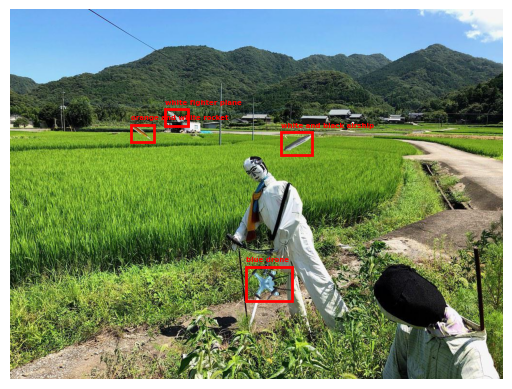

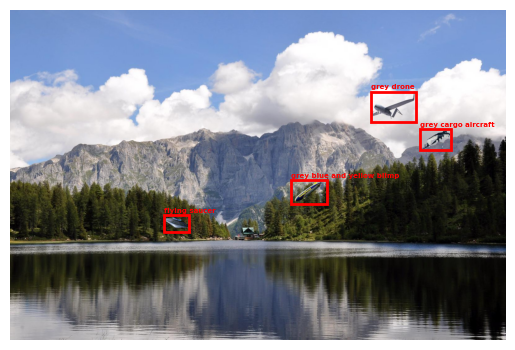

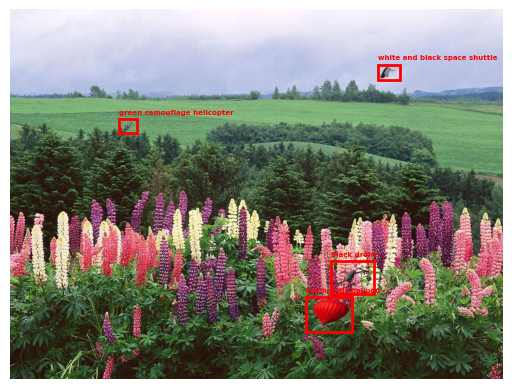

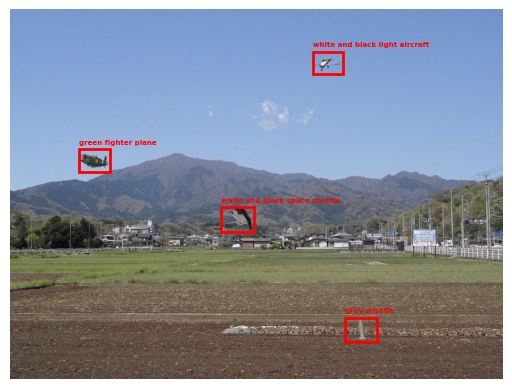

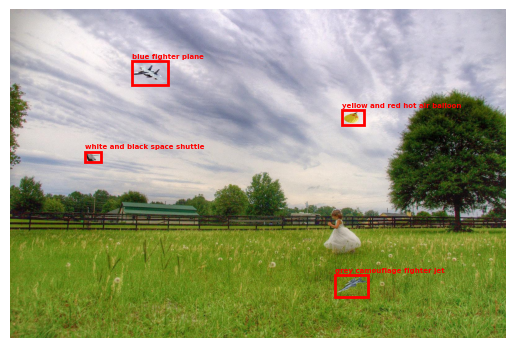

In [ ]:
import json
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Paths to the JSON file and the folder with the new images
annotations_json_path = '/content/drive/MyDrive/TIL_personal/annotations.json'
images_dir = '/content/drive/MyDrive/TIL_personal/images_integrated'

# Load the annotations from the JSON file
with open(annotations_json_path, 'r') as json_file:
    annotations_data = json.load(json_file)

# Select 5 random images
random_annotations = random.sample(annotations_data, 5)

# Function to display an image with bounding boxes
def show_image_with_bboxes(image_path, annotations):
    with Image.open(image_path) as img:
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        for annotation in annotations:
            bbox = annotation['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(bbox[0], bbox[1] - 10, annotation['caption'], color='red', fontsize=5, weight='bold')

        plt.axis('off')
        plt.show()

# Display the 5 selected images with their bounding boxes
for annotation in random_annotations:
    image_name = annotation['image']
    image_path = os.path.join(images_dir, image_name)
    show_image_with_bboxes(image_path, annotation['annotations'])